In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import PIL.Image as Imag 
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader

In [2]:
path = "data/Images/"
path_for_hist = "data/perfect_images/"
dataset_total = pd.read_csv("dataset label.csv")
destination_dir = 'validation_set/'
image_size = (512,512)

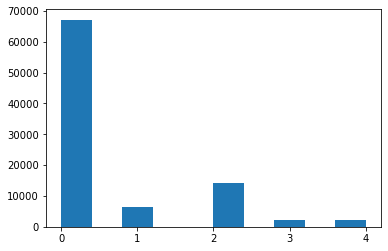

In [3]:
dataset_total.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [4]:
def extract_bv(image):
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)

    # applying alternate sequential filtering (3 times closing opening)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)	
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    f5 = clahe.apply(f4)

    # removing very small contours through area parameter noise removal
    ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)	
    mask = np.ones(f5.shape[:2], dtype="uint8") * 255	
    contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=mask)
    ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)	
    xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"	
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)

    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
    blood_vessels = cv2.bitwise_not(finimage)
    return blood_vessels

#FOR TAGGING
def blurry_or_not(laplacian_value):
    
    if laplacian_value <10000:
        return 0
    else:
        return 1
  
    

In [5]:
def preprocess_image(image):
    # Ensure image is color image with 3 channels

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(10,10))
    l_normalized = clahe.apply(l)
    normalized_lab = cv2.merge((l_normalized, a, b))
    normalized_bgr = cv2.cvtColor(normalized_lab, cv2.COLOR_LAB2BGR)

    return normalized_bgr

In [6]:
import random
def show_images_by_level(filter=None):
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
    axs = axs.flatten()

    images_by_level = {level: [] for level in range(5)}
    for i in range(2000):
        i = random.randint(0,1000)
        
        level = dataset_total["level"][i]
        image_path = f'{path}{dataset_total["image"][i]}.jpg'
        image = cv2.imread(image_path)
        image = cv2.resize(image,image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if filter is not None:
            for j in range(len(filter)):
                image = filter[j](image)
        images_by_level[level].append(image)

    for i, level in enumerate(range(5)):
        images = images_by_level[level][:5]
        for j in range(len(images)):

            axs[5 * j + i].imshow((images[j]))
            axs[5 * j + i].set_title(f'Level: {level}')
            axs[5 * j + i].axis('off')
            # Add label to the bottom of the image
            axs[5 * j + i].text(0.5, -0.1, (cv2.Laplacian(extract_bv(images[j]), cv2.CV_64F).var()), transform=axs[5 * j + i].transAxes,
                                 fontsize=12, ha='center', va='bottom')
            
    plt.tight_layout()
    plt.show()

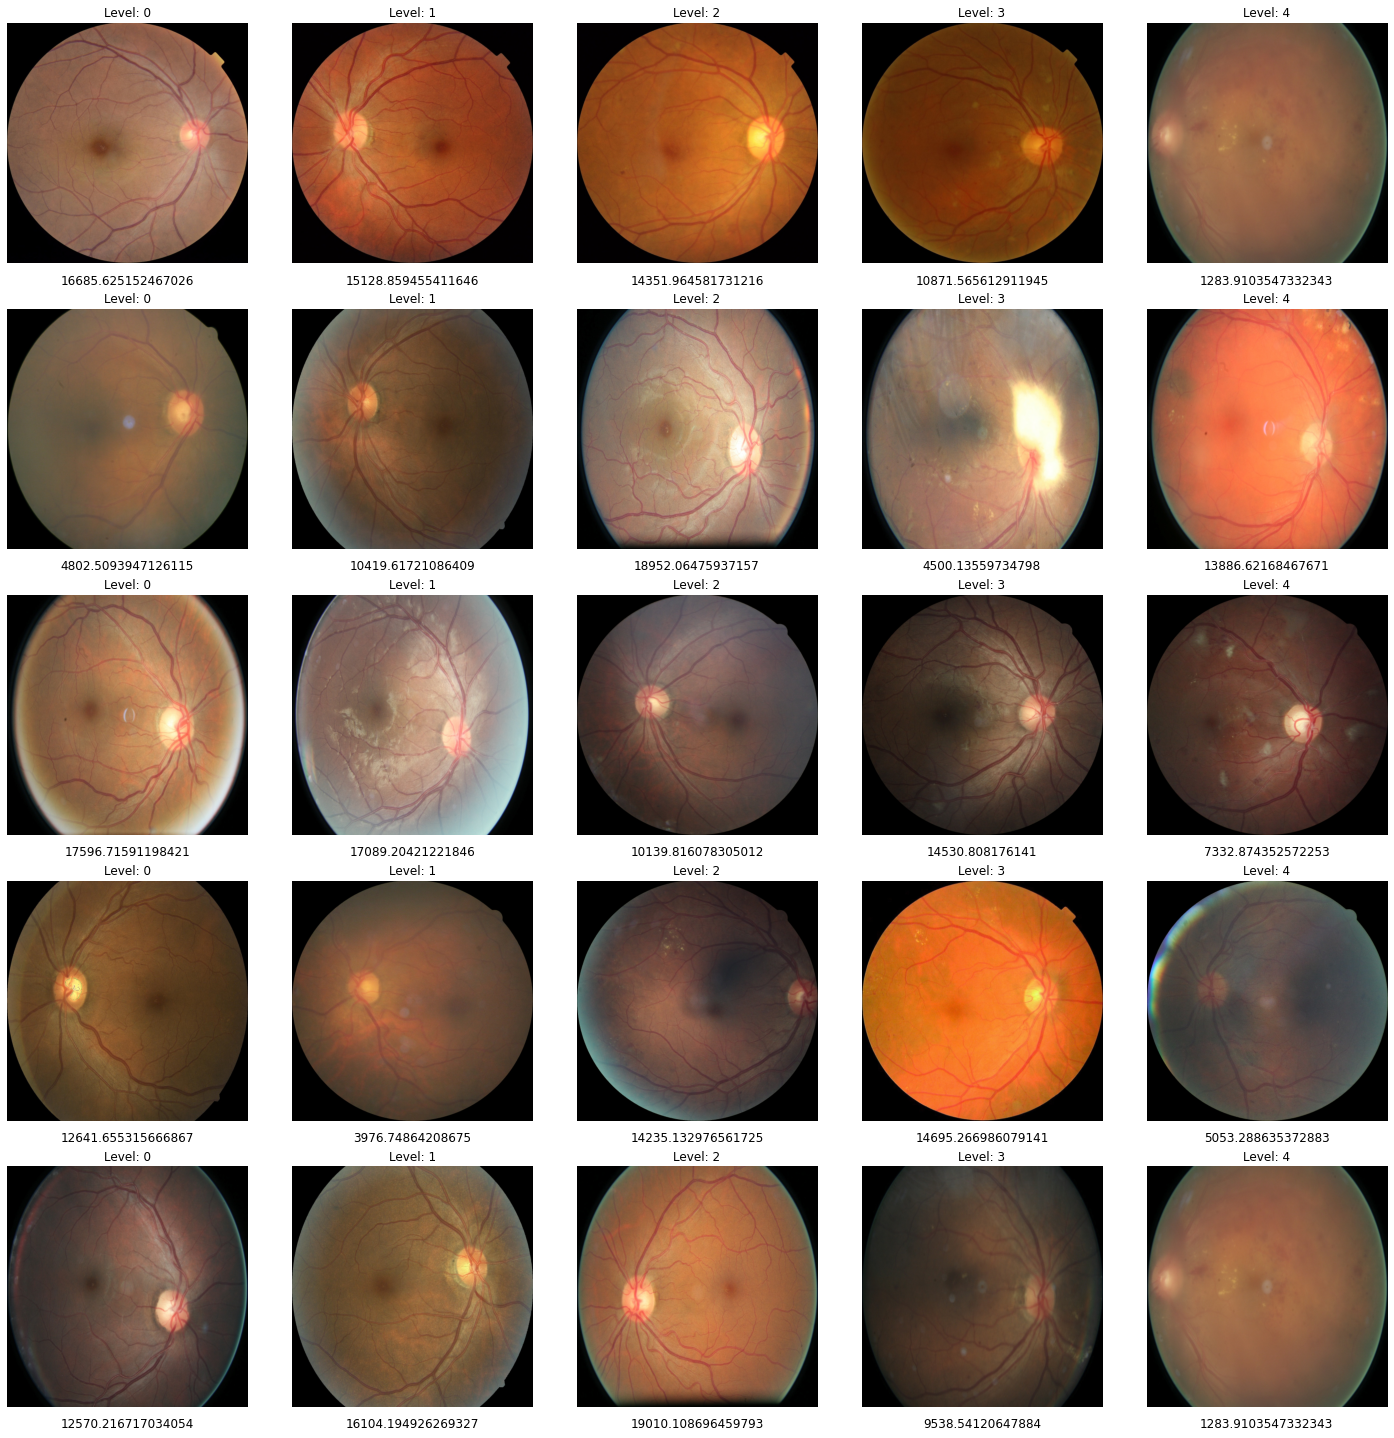

In [7]:
show_images_by_level(filter =[])

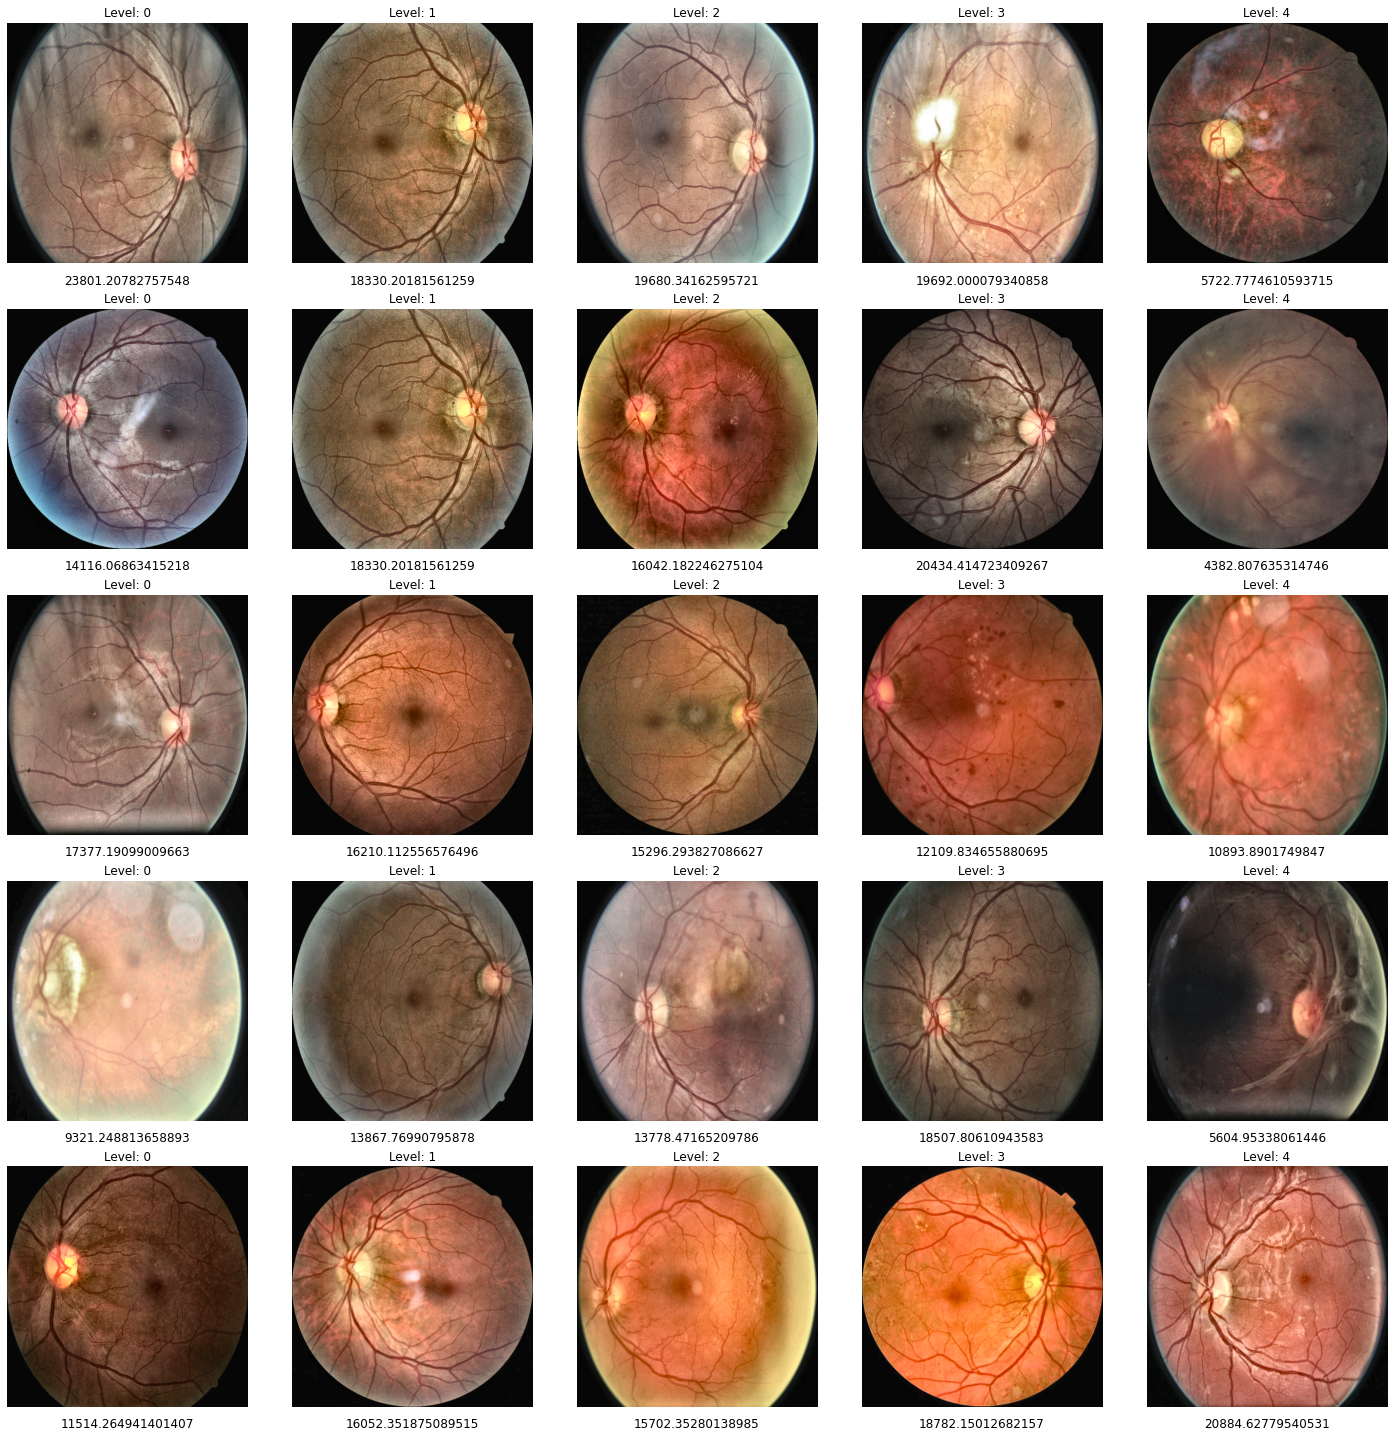

In [8]:
show_images_by_level(filter =[preprocess_image])

In [19]:
total = []
for i in range(0,len(dataset_total)):
        if dataset_total["validation"][i] == 0 and dataset_total["classification"][i]==0:
        
                try:
                        number_of_defected = 0
                        image_path = f'{path}{dataset_total["image"][i]}.jpg'
                        image = cv2.imread(image_path)
                        image = cv2.resize(image,image_size)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        dataset_total["classification"][i] =  (blurry_or_not(cv2.Laplacian(extract_bv(image), cv2.CV_64F).var()))
                        if i % 1000 == 0 :
                                print(f"%{i/len(dataset_total)} is finished")

                except:
                        print(f"the image number of {i} has problem" )
       
print(total)


%0.0 is finished
%0.010826729028625871 is finished
%0.021653458057251742 is finished
%0.03248018708587761 is finished
%0.043306916114503484 is finished
%0.05413364514312936 is finished
%0.06496037417175522 is finished
%0.0757871032003811 is finished
%0.08661383222900697 is finished
%0.09744056125763284 is finished
%0.10826729028625871 is finished
%0.11909401931488459 is finished
%0.12992074834351044 is finished
%0.14074747737213633 is finished
%0.1515742064007622 is finished
%0.16240093542938808 is finished
%0.17322766445801394 is finished
%0.18405439348663982 is finished
%0.19488112251526568 is finished
%0.20570785154389157 is finished
%0.21653458057251743 is finished
%0.2273613096011433 is finished
%0.23818803862976917 is finished
%0.24901476765839506 is finished
%0.2598414966870209 is finished
%0.2706682257156468 is finished
%0.28149495474427266 is finished
%0.2923216837728985 is finished
%0.3031484128015244 is finished
%0.3139751418301503 is finished
%0.32480187085877615 is finishe

In [184]:
save_dir_class1 = "aug_images_class1/"
save_dir_class2 = "aug_images_class2/"
save_dir_class3 = "aug_images_class3/"
save_dir_class4 = "aug_images_class4/"

In [185]:
import os

In [ ]:

while int(len(os.listdir(save_dir_class1))) < 10000:
    for i in range(0,len(dataset_total)):
            if dataset_total["level"][i] == 1:
                for j in range(0,15):
                    image = (augment_image(cv2.imread(f'{path}{dataset_total["image"][i]}.jpg')))
                    b,g,r = cv2.split(image)
                    Image = cv2.merge([r,g,b])
                    save_path = save_dir_class1+f"Aug_1_{len(os.listdir(save_dir_class1))}.jpg"
                    cv2.imwrite(save_path, image)



In [ ]:
while int(len(os.listdir(save_dir_class3))) < 10000:
    for i in range(0,len(dataset_total)):
            if dataset_total["level"][i] == 3:
                for j in range(0,15):
                    image = (augment_image(cv2.imread(f'{path}{dataset_total["image"][i]}.jpg')))
                    b,g,r = cv2.split(image)
                    Image = cv2.merge([r,g,b])
                    save_path = save_dir_class3+f"Aug_3_{len(os.listdir(save_dir_class3))}.jpg"
                    cv2.imwrite(save_path, image)                                       


In [ ]:
while int(len(os.listdir(save_dir_class4))) < 10000:
    for i in range(0,len(dataset_total)):
            if dataset_total["level"][i] == 4:
                for j in range(0,15):
                    image = (augment_image(cv2.imread(f'{path}{dataset_total["image"][i]}.jpg')))
                    b,g,r = cv2.split(image)
                    Image = cv2.merge([r,g,b])
                    save_path = save_dir_class4+f"Aug_4_{len(os.listdir(save_dir_class4))}.jpg"
                    cv2.imwrite(save_path, image)
                
        

In [ ]:
while int(len(os.listdir(save_dir_class2))) < 10000:
    for i in range(0,len(dataset_total)):
            if dataset_total["level"][i] == 2:
                for j in range(0,15):
                    image = (augment_image(cv2.imread(f'{path}{dataset_total["image"][i]}.jpg')))
                    b,g,r = cv2.split(image)
                    Image = cv2.merge([r,g,b])
                    save_path = save_dir_class2+f"Aug_2_{len(os.listdir(save_dir_class2))}.jpg"
                    cv2.imwrite(save_path, image)

In [67]:
img_files1 = os.listdir(save_dir_class1)
img_files2 = os.listdir(save_dir_class2)
img_files3 = os.listdir(save_dir_class3)
img_files4 = os.listdir(save_dir_class4)
img_names1 = [os.path.splitext(f)[0] for f in img_files1] 
img_names2 = [os.path.splitext(f)[0] for f in img_files2]
img_names3 = [os.path.splitext(f)[0] for f in img_files3]
img_names4 = [os.path.splitext(f)[0] for f in img_files4]
df1 = pd.DataFrame({'image': img_names1,"level":1,"validation":0})
df2 = pd.DataFrame({'image': img_names2,"level":2,"validation":0})
df3 = pd.DataFrame({'image': img_names3,"level":3,"validation":0})
df4 = pd.DataFrame({'image': img_names4,"level":4,"validation":0})

In [70]:
dataset_total.drop(columns=["Unnamed: 0"],inplace=True)
total_label = pd.concat([dataset_total,df1,df2,df3,df4])
total_label = total_label.reset_index()
total_label.drop(columns=["index"],inplace = True)
total_label.to_csv("total_label.csv")
label_total = pd.read_csv("total_label.csv")



In [ ]:
label_for_level_1 = label_total[label_total['level'] == 1]
label_for_level_2 = label_total[label_total['level'] == 2]
label_for_level_0 = label_total[label_total['level'] == 0]
label_for_level_3 = label_total[label_total['level'] == 3]
label_for_level_4 = label_total[label_total['level'] == 4]

In [ ]:
df_level_4_not_aug = label_for_level_4[~label_for_level_4['image'].str.contains('Aug')]
df_level_3_not_aug = label_for_level_3[~label_for_level_3['image'].str.contains('Aug')]
df_level_2_not_aug = label_for_level_2[~label_for_level_2['image'].str.contains('Aug')]
df_level_1_not_aug = label_for_level_1[~label_for_level_1['image'].str.contains('Aug')]
df_level_0_not_aug = label_for_level_0[~label_for_level_0['image'].str.contains('Aug')]

In [29]:
import os
source_dir = 'data/Images'
destination_dir = 'data/validation_images'

# Loop through the DataFrame and move images to the destination directory based on the level
for i, row in df_level_1_not_aug[-500:].iterrows():
    image_name = row['image']
    level = row['level']
 
    src_path = f"{source_dir}/{image_name}.jpg"
    dst_path = f"{destination_dir}/{image_name}.jpg"
    os.rename(src_path, dst_path)


# Loop through the DataFrame and move images to the destination directory based on the level
for i, row in df_level_2_not_aug[-500:].iterrows():
    image_name = row['image']
    level = row['level']
 
    src_path = f"{source_dir}/{image_name}.jpg"
    dst_path = f"{destination_dir}/{image_name}.jpg"
    os.rename(src_path, dst_path)

# Loop through the DataFrame and move images to the destination directory based on the level
for i, row in df_level_3_not_aug[-500:].iterrows():
    image_name = row['image']
    level = row['level']
 
    src_path = f"{source_dir}/{image_name}.jpg"
    dst_path = f"{destination_dir}/{image_name}.jpg"
    os.rename(src_path, dst_path)

# Loop through the DataFrame and move images to the destination directory based on the level
for i, row in df_level_4_not_aug[-500:].iterrows():
    image_name = row['image']
    level = row['level']
 
    src_path = f"{source_dir}/{image_name}.jpg"
    dst_path = f"{destination_dir}/{image_name}.jpg"
    os.rename(src_path, dst_path)
for i, row in df_level_0_not_aug[-500:].iterrows():
    image_name = row['image']
    level = row['level']
 
    src_path = f"{source_dir}/{image_name}.jpg"
    dst_path = f"{destination_dir}/{image_name}.jpg"
    os.rename(src_path, dst_path)
validation_dir = 'data/validation_images/'
import os
validation_images = [f.split('.')[0] for f in os.listdir(validation_dir)]
validation_images
dataset_total['validation'] = dataset_total['image'].apply(lambda x: 1 if x in validation_images else 0)
  

In [ ]:
dataset_total[dataset_total["validation"] ==1]
total_label = pd.concat([dataset_total,df1,df2,df3,df4])
total_label = total_label.reset_index()
total_label.drop(columns=["index"],inplace = True)
total_label.to_csv("total_label.csv")
label_total = pd.read_csv("total_label.csv")
label_for_level_1 = label_total[label_total['level'] == 1]
label_for_level_2 = label_total[label_total['level'] == 2]
label_for_level_0 = label_total[label_total['level'] == 0]
label_for_level_3 = label_total[label_total['level'] == 3]
label_for_level_4 = label_total[label_total['level'] == 4]
df_level_4_not_aug = label_for_level_4[~label_for_level_4['image'].str.contains('Aug')]
df_level_3_not_aug = label_for_level_3[~label_for_level_3['image'].str.contains('Aug')]
df_level_2_not_aug = label_for_level_2[~label_for_level_2['image'].str.contains('Aug')]
df_level_1_not_aug = label_for_level_1[~label_for_level_1['image'].str.contains('Aug')]
df_level_0_not_aug = label_for_level_0[~label_for_level_0['image'].str.contains('Aug')]

In [ ]:
dataset_total.to_csv("total_label.csv")